# Import Data

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Pandas used to import dataset, additional libraries are added for use later in code.

In [13]:
df = pd.read_csv('data.csv')

In [14]:
df.head()

,name,MDVP:Fo(Hz),MDVP:Fhi(Hz),MDVP:Flo(Hz),MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,...,Shimmer:DDA,NHR,HNR,RPDE,DFA,spread1,spread2,D2,PPE,status
0,phon_R01_S01_1,119.992,157.302,74.997,0.00784,0.00007,0.00370,0.00554,0.01109,0.04374,...,0.06545,0.02211,21.033,0.414783,0.815285,-4.813031,0.266482,2.301442,0.284654,1
1,phon_R01_S01_2,122.400,148.650,113.819,0.00968,0.00008,0.00465,0.00696,0.01394,0.06134,...,0.09403,0.01929,19.085,0.458359,0.819521,-4.075192,0.335590,2.486855,0.368674,1
2,phon_R01_S01_3,116.682,131.111,111.555,0.01050,0.00009,0.00544,0.00781,0.01633,0.05233,...,0.08270,0.01309,20.651,0.429895,0.825288,-4.443179,0.311173,2.342259,0.332634,1
3,phon_R01_S01_4,116.676,137.871,111.366,0.00997,0.00009,0.00502,0.00698,0.01505,0.05492,...,0.08771,0.01353,20.644,0.434969,0.819235,-4.117501,0.334147,2.405554,0.368975,1
4,phon_R01_S01_5,116.014,141.781,110.655,0.01284,0.00011,0.00655,0.00908,0.01966,0.06425,...,0.10470,0.01767,19.649,0.417356,0.823484,-3.747787,0.234513,2.332180,0.410335,1


Display data table

# Split Dataset

In [15]:
x = df.loc[:,'MDVP:Fo(Hz)':'PPE'].values
y = df.loc[:,'status'].values

In [16]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = \
    train_test_split(x,y,
                        test_size = 0.2,
                        stratify = y,
                        random_state = 1)

Splitting the data for training a knn classifier in a holdout + cross-validation fashion. Split data is used to establish graphs plotted later in code.

In [17]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline

In [18]:
pipe_K = make_pipeline(StandardScaler(),PCA(n_components=2),KNeighborsClassifier())

In [19]:
pipe_K.fit(x_train, y_train)
y_predict = pipe_K.predict(x_test)
print('TEST ACCURACY: %.3f'% pipe_K.score(x_test,y_test))

TEST ACCURACY: 0.846


Find the test accuracy using the "make_pipeline" function to establish pipe_K.

In [20]:
from sklearn.grid_search import GridSearchCV

k = [4,5,6,7,8,9,10]
param_grid = [{'kneighborsclassifier__n_neighbors': k}]

grids = GridSearchCV(estimator=pipe_K, param_grid=param_grid, scoring='accuracy', cv = 5)

grids = grids.fit(x_train, y_train)
print(grids.best_score_)
print(grids.best_params_)

0.8974358974358975
{'kneighborsclassifier__n_neighbors': 5}


Imput k values into the k-nearest neighbors classifier. Then, using Grid Search, identify the optimal k.

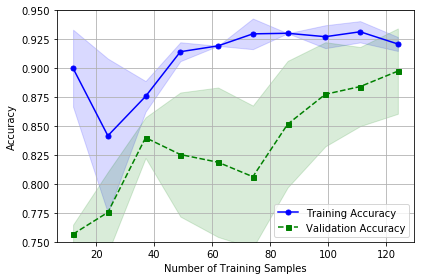

In [21]:
from sklearn.model_selection import learning_curve
train_sizes, train_scores, test_scores = \
                learning_curve(estimator = pipe_K, X = x_train, y = y_train,
                              train_sizes=np.linspace(0.1, 1.0, 10), cv = 5, n_jobs=1)

train_mean = np.mean(train_scores, axis = 1)
train_std = np.std(train_scores, axis = 1)
test_mean = np.mean(test_scores, axis = 1)
test_std = np.std(test_scores, axis = 1)

plt.plot(train_sizes, train_mean, color = 'blue', marker = 'o',
        markersize = 5, label = 'Training Accuracy')

plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std,
                alpha = 0.15, color = 'blue')

plt.plot(train_sizes, test_mean, color = 'green', linestyle = '--', marker = 's', 
         markersize = 5, label = 'Validation Accuracy')

plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std,
                alpha = 0.15, color = 'green')

plt.grid()
plt.xlabel('Number of Training Samples')
plt.ylabel('Accuracy')
plt.legend(loc = 'lower right')
plt.ylim([0.75, .95])
plt.tight_layout()
plt.show()

The code above is the graph setup for the learning curve using matplotlib. Train data and test data are separated into 2 separate colors and marker types. Then, the "fill-between" function is used to connect data points, with a dotted connector for the validation accuracy. I limited the y scale in order to show all data points without including extra space.

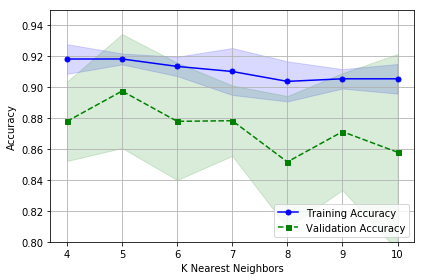

In [22]:
from sklearn.model_selection import validation_curve

train_scores, test_scores = validation_curve(estimator = pipe_K, X = x_train, y = y_train,
                param_name = 'kneighborsclassifier__n_neighbors', param_range = k, cv = 5)

train_mean = np.mean(train_scores, axis = 1)
train_std = np.std(train_scores, axis = 1)
test_mean = np.mean(test_scores, axis = 1)
test_std = np.std(test_scores, axis = 1)

plt.plot(k, train_mean, color = 'blue', marker = 'o', markersize = 5, 
         label = 'Training Accuracy')

plt.fill_between(k, train_mean + train_std, train_mean - train_std,
                alpha = 0.15, color = 'blue')

plt.plot(k, test_mean, color = 'green', linestyle = '--', marker = 's', markersize = 5,
         label = 'Validation Accuracy')

plt.fill_between(k, test_mean + test_std, test_mean - test_std,
                alpha = 0.15, color = 'green')

plt.grid()
plt.legend(loc = 'lower right')
plt.xlabel('K Nearest Neighbors')
plt.ylabel('Accuracy')
plt.ylim([0.8, .95])
plt.tight_layout()
plt.show()

The code above is the graph setup for the validation curve using matplotlib. Train data and test data are separated into 2 separate colors and marker types. Then, the "fill-between" function is used to connect data points, with a dotted connector for the validation accuracy. I limited the y scale in order to show all data points without including extra space.